# Defining functions

In [1]:
from __future__ import annotations

import json
import math
import re
from datetime import datetime
from pathlib import Path
from typing import Iterable, Optional, Sequence

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image


def _load_json(p: Path):
    with p.open("r", encoding="utf-8") as f:
        return json.load(f)


def plot_eval_acc_max_per_group(
    dataset_dir: str | Path,
    *,
    group_by: tuple[str, ...] = ("dropout", "augment"),
    show_print: bool = False,
    show_plot: bool = True,
    save_path: str | Path | None = None,
):
    """
    For a dataset folder like runs/LENET5/CIFAR10 or runs/LENET5/GTSRB:
      - reads all run subfolders with config.json + history.json
      - groups runs by keys in `group_by` (default: dropout + augment)
      - for each group picks the run with the maximum number of epochs
        (measured by len(history['eval_acc']) or config['epochs'])
      - plots eval_acc vs epoch per group (linestyle by augment)

    This matches your CIFAR10 situation where aug=1 was trained longer than aug=0.
    """
    dataset_dir = Path(dataset_dir)
    if not dataset_dir.exists() or not dataset_dir.is_dir():
        raise ValueError(f"dataset_dir does not exist or is not a dir: {dataset_dir}")

    # collect run dirs (your structure: dataset_dir/<run_name>/config.json etc.)
    run_dirs = [
        p for p in dataset_dir.iterdir()
        if p.is_dir() and (p / "config.json").exists() and (p / "history.json").exists()
    ]
    if not run_dirs:
        raise RuntimeError(f"No run folders with config.json+history.json found in: {dataset_dir}")

    runs = []
    for rd in run_dirs:
        try:
            cfg = _load_json(rd / "config.json")
            hist = _load_json(rd / "history.json")
        except Exception as e:
            print(f"[WARN] Skip {rd}: cannot read json ({e})")
            continue

        eval_acc = hist.get("eval_acc")
        if not isinstance(eval_acc, list) or len(eval_acc) == 0:
            print(f"[WARN] Skip {rd}: missing/empty history['eval_acc']")
            continue

        # parse fields (your config keys)
        try:
            dropout = float(cfg.get("dropout"))
        except Exception:
            dropout = cfg.get("dropout")

        try:
            augment = int(cfg.get("augment"))
        except Exception:
            augment = cfg.get("augment")

        # config epochs might exist but we primarily trust eval_acc length
        cfg_epochs = cfg.get("epochs")
        try:
            cfg_epochs = int(cfg_epochs)
        except Exception:
            cfg_epochs = None

        runs.append(
            {
                "run_dir": rd,
                "cfg": cfg,
                "eval_acc": eval_acc,
                "dropout": dropout,
                "augment": augment,
                "cfg_epochs": cfg_epochs,
            }
        )

    if not runs:
        raise RuntimeError(f"Found run dirs, but none were usable in: {dataset_dir}")

    # group and select max epochs run per group
    best = {}
    for r in runs:
        key_parts = []
        for k in group_by:
            if k == "dropout":
                key_parts.append(r["dropout"])
            elif k == "augment":
                key_parts.append(r["augment"])
            else:
                key_parts.append(r["cfg"].get(k))
        key = tuple(key_parts)

        # "epochs achieved" = length of eval_acc (most reliable)
        achieved_epochs = len(r["eval_acc"])

        if key not in best or achieved_epochs > len(best[key]["eval_acc"]):
            best[key] = r

    if show_print:
        print(f"\nDataset: {dataset_dir.name}")
        print(f"Runs found (usable): {len(runs)}")
        print(f"Groups ({group_by}) plotted: {len(best)}")
        for key, r in sorted(best.items(), key=lambda x: tuple(str(v) for v in x[0])):
            print("-" * 90)
            print(f"group={key} | run={r['run_dir'].name} | epochs_used={len(r['eval_acc'])}")

    # plot
    if show_plot or save_path is not None:
        # linestyle by augmentation (extend as needed)
        ls_map = {0: "-", 1: "--"}

        plt.figure(figsize=(10, 6))
        for key, r in sorted(best.items(), key=lambda x: tuple(str(v) for v in x[0])):
            y = r["eval_acc"]
            x = list(range(1, len(y) + 1))

            aug = r["augment"]
            ls = ls_map.get(aug, "-.")
            label = f"dropout={r['dropout']}, aug={aug}, epochs={len(y)}"

            plt.plot(x, y, linestyle=ls, label=label)

        plt.xlabel("epoch")
        plt.ylabel("test accuracy")
        plt.title(f"{dataset_dir.name}: test accuracy vs epoch (max epochs per group)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()

        if save_path is not None:
            save_path = Path(save_path)
            save_path.parent.mkdir(parents=True, exist_ok=True)
            plt.savefig(save_path, dpi=200)

        if show_plot:
            plt.show()
        else:
            plt.close()

    return best

In [2]:
def _load_json(p: Path):
    with p.open("r", encoding="utf-8") as f:
        return json.load(f)


def _mean(xs):
    return sum(xs) / len(xs) if xs else float("nan")


def _std(xs):
    if not xs:
        return float("nan")
    m = _mean(xs)
    return math.sqrt(sum((x - m) ** 2 for x in xs) / len(xs))


def load_best_runs_per_group(dataset_dir: str | Path):
    """
    Returns dict: (dropout, augment) -> run_dict
    Picks the run with the longest eval_acc for each group.
    """
    dataset_dir = Path(dataset_dir)
    run_dirs = [
        p for p in dataset_dir.iterdir()
        if p.is_dir() and (p / "config.json").exists() and (p / "history.json").exists()
    ]

    runs = []
    for rd in run_dirs:
        cfg = _load_json(rd / "config.json")
        hist = _load_json(rd / "history.json")

        eval_acc = hist.get("eval_acc", [])
        train_t = hist.get("train_time_s", [])
        eval_t = hist.get("eval_time_s", [])

        if not eval_acc or not train_t or not eval_t:
            continue

        dropout = float(cfg.get("dropout"))
        augment = int(cfg.get("augment"))

        epochs_cfg = int(cfg.get("epochs"))


        runs.append({
            "run_dir": rd,
            "dropout": dropout,
            "augment": augment,
            "eval_acc": eval_acc,
            "train_time_s": train_t,
            "eval_time_s": eval_t,
            "epochs_cfg": epochs_cfg,
        })

    best = {}
    for r in runs:
        key = (r["dropout"], r["augment"])
        if key not in best or len(r["eval_acc"]) > len(best[key]["eval_acc"]):
            best[key] = r




    if not best:
        raise RuntimeError(f"No usable runs found in {dataset_dir}")
    
    # if is_cifar10 and not best:
    #     raise RuntimeError("CIFAR10: no runs found with epochs_cfg == 15. Train ep=15 for aug=1 too.")


    return best


def runtime_summary(best_runs: dict, threshold: float = 0.60):
    """
    Build summary rows per (dropout, augment).
    Adds:
      - best_test_acc_epoch (epoch index where max test acc occurs; 1-based)
      - time_to_best_test_acc_train_s (cumulative train time up to that epoch)
    """
    rows = []
    for (dropout, aug), r in sorted(best_runs.items(), key=lambda x: (x[0][1], x[0][0])):
        train_t = r["train_time_s"]
        eval_t = r["eval_time_s"]
        acc = r["eval_acc"]  # treated as TEST accuracy

        total_train = sum(train_t)
        total_eval = sum(eval_t)
        total = total_train + total_eval

        mean_train = _mean(train_t)
        std_train = _std(train_t)
        mean_eval = _mean(eval_t)
        std_eval = _std(eval_t)

        # best (max) test accuracy and the epoch where it happens
        best_idx = max(range(len(acc)), key=lambda i: acc[i])
        max_acc = acc[best_idx]
        best_epoch = best_idx + 1  # 1-based for readability

        # cumulative train time until best epoch (inclusive)
        time_to_best = sum(train_t[:best_epoch])

        # time to reach threshold (in train time only)
        t_to_thr = None
        cum_train = 0.0
        for a, t in zip(acc, train_t):
            cum_train += t
            if a >= threshold:
                t_to_thr = cum_train
                break

        rows.append({
            "dropout": dropout,
            "augment": aug,
            "epochs": len(acc),

            # "eval" -> "test" in naming
            "max_test_acc": max_acc,
            "best_test_acc_epoch": best_epoch,
            "time_to_best_test_acc_train_s": time_to_best,

            "total_train_s": total_train,
            "total_eval_s": total_eval,
            "total_s": total,
            "train_s_per_epoch_mean": mean_train,
            "train_s_per_epoch_std": std_train,
            "eval_s_per_epoch_mean": mean_eval,
            "eval_s_per_epoch_std": std_eval,
            f"time_to_{threshold:.2f}_train_s": t_to_thr,
        })
    return rows


def print_runtime_table(rows):
    cols = [
        "dropout", "augment", "epochs",
        "max_test_acc", "best_test_acc_epoch",
        "total_train_s", "total_eval_s", "total_s",
        "train_s_per_epoch_mean", "eval_s_per_epoch_mean",
    ]
    header = " | ".join(f"{c:>24}" for c in cols)
    print(header)
    print("-" * len(header))
    for row in rows:
        parts = []
        for c in cols:
            v = row[c]
            if isinstance(v, float):
                parts.append(f"{v:>24.4f}")
            else:
                parts.append(f"{str(v):>24}")
        print(" | ".join(parts))


def plot_total_time(rows, title="Total training time per config", dataset_name=None, normalize_epochs=None):
    plt.figure(figsize=(10, 5))
    labels = [f"do={r['dropout']}, aug={r['augment']}" for r in rows]
    # values = [r["total_train_s"] for r in rows]
    values = []
    is_cifar10 = (dataset_name is not None and dataset_name.lower() == "cifar10")
    target = normalize_epochs if normalize_epochs is not None else 15

    for r in rows:
        if is_cifar10:
            # normalize to "target epochs" using mean seconds per epoch
            values.append(r["train_s_per_epoch_mean"] * target)
        else:
            values.append(r["total_train_s"])

    plt.bar(labels, values)
    plt.xticks(rotation=30, ha="right")
    # plt.ylabel("total train time (s)")
    if dataset_name is not None and dataset_name.lower() == "cifar10":
        plt.ylabel(f"train time normalized to {target} epochs (s)")
    else:
        plt.ylabel("total train time (s)")

    plt.title(title)
    plt.tight_layout()
    plt.show()


def plot_efficiency(rows, title="Max test accuracy vs total train time", dataset_name=None):
    plt.figure(figsize=(7, 5))
    for r in rows:
        plt.scatter(r["total_train_s"], r["max_test_acc"])
        # include the epoch where max is reached
        plt.text(
            r["total_train_s"],
            r["max_test_acc"],
            f"do={r['dropout']}, aug={r['augment']}, ep={r['best_test_acc_epoch']}",
            fontsize=8
        )
    plt.xlabel("total train time (s)")
    plt.ylabel("max test accuracy")
    plt.title(title)
    plt.grid(True)
    # Make CIFAR10 easier to read (adjust limits as you prefer)
    if dataset_name is not None and dataset_name.lower() == "cifar10":
        plt.ylim(0.58, 0.67)   # Beispiel: größerer Bereich

    plt.tight_layout()
    plt.show()



In [3]:

def show_confusion_pngs_for_setting(
    dataset_dir: str | Path,
    *,
    dropout: float = 0.0,
    augment: int = 0,
):
    """
    Prints the paths to the confusion-matrix PNGs for:
      - augment=augment, dropout=dropout, MIN epochs_cfg
      - augment=augment, dropout=dropout, MAX epochs_cfg

    Assumptions:
      - structure: <dataset_dir>/<run_name>/config.json
      - each run folder contains ONE confusion-matrix png (we search by common name patterns)
    """
    dataset_dir = Path(dataset_dir)

    def load_cfg(run_dir: Path):
        return json.loads((run_dir / "config.json").read_text(encoding="utf-8"))

    def find_cm_png(run_dir: Path):
        p = run_dir / "confusion_matrix.png"
        return [p] if p.exists() else []


    # collect candidate runs
    candidates = []
    for run_dir in dataset_dir.iterdir():
        if not run_dir.is_dir():
            continue
        cfg_path = run_dir / "config.json"
        if not cfg_path.exists():
            continue

        cfg = load_cfg(run_dir)
        hist = json.loads((run_dir / "history.json").read_text(encoding="utf-8"))


        try:
            do = float(cfg.get("dropout"))
            aug = int(cfg.get("augment"))
            ep = int(cfg.get("epochs"))
        except Exception:
            continue

        if abs(do - dropout) > 1e-12 or aug != augment:
            continue

        pngs = find_cm_png(run_dir)
        if not pngs:
            continue

        candidates.append((ep, run_dir, pngs, cfg.get("created_at"), hist))


    if not candidates:
        print(f"No confusion PNGs found for dropout={dropout}, augment={augment} in {dataset_dir}")
        return

    min_ep = min(ep for ep, *_ in candidates)
    max_ep = max(ep for ep, *_ in candidates)

    # in case multiple runs share same epoch value, pick latest by folder name (usually timestamped)
    def pick_latest_for_epoch(epoch_val: int):
        same = [c for c in candidates if c[0] == epoch_val]
        same.sort(key=lambda x: x[1].name)  # folder name
        return same[-1]

    min_run = pick_latest_for_epoch(min_ep)
    max_run = pick_latest_for_epoch(max_ep)

    def show_minmax_side_by_side(label_prefix, run_min, run_max):
        ep_min, dir_min, pngs_min, _, hist_min = run_min
        ep_max, dir_max, pngs_max, _, hist_max = run_max


        p_min = pngs_min[0]
        p_max = pngs_max[0]

        acc_min = hist_min.get("eval_acc", [])
        acc_max = hist_max.get("eval_acc", [])

        last_min = acc_min[-1] if acc_min else None
        last_max = acc_max[-1] if acc_max else None

        best_min = max(acc_min) if acc_min else None
        best_max = max(acc_max) if acc_max else None

        print(f"{label_prefix} | MIN epochs={ep_min} | last test acc={last_min:.4f}")
        print(f"{label_prefix} | MAX epochs={ep_max} | last test acc={last_max:.4f}")


        img_min = Image.open(p_min)
        img_max = Image.open(p_max)

        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(img_min)
        axes[0].axis("off")
        axes[1].imshow(img_max)
        axes[1].axis("off")
        plt.tight_layout()
        plt.show()


    show_minmax_side_by_side(f"dropout={dropout}, aug={augment}", min_run, max_run)




In [4]:
def _load_json(p: Path):
    with p.open("r", encoding="utf-8") as f:
        return json.load(f)


def _parse_created_at(cfg: dict):
    s = cfg.get("created_at")
    if not s:
        return None
    try:
        return datetime.fromisoformat(s)
    except Exception:
        return None

def build_lenet5_best_per_config_df(
    runs_root: str | Path,
    dataset: str,
    *,
    group_keys=("dropout", "augment"),
    out_csv_path: str | Path | None = None,
) -> pd.DataFrame:
    """
    - Scans runs_root recursively for run folders containing: config.json, history.json, metrics.json
    - Filters to model=lenet5 and dataset=<dataset>
    - Groups by group_keys (default: dropout+augment)
    - For each group, selects the run with the HIGHEST config['epochs']
      (tie-break: newest created_at, else folder name)
    - For the selected run, computes metrics AT BEST EPOCH ONLY:
        * best_test_acc
        * best_test_acc_epoch (1-based)
        * total_train_s  (sum up to best epoch)
        * total_test_s   (sum up to best epoch)
    """

    runs_root = Path(runs_root)
    dataset_lc = dataset.lower()

    # Collect candidates
    candidates = []
    for cfg_path in runs_root.rglob("config.json"):
        run_dir = cfg_path.parent
        hist_path = run_dir / "history.json"
        met_path = run_dir / "metrics.json"

        if not hist_path.exists() or not met_path.exists():
            continue

        cfg = _load_json(cfg_path)

        if str(cfg.get("model", "")).lower() != "lenet5":
            continue
        if str(cfg.get("dataset", "")).lower() != dataset_lc:
            continue

        try:
            epochs_cfg = int(cfg.get("epochs"))
        except Exception:
            continue

        hist = _load_json(hist_path)

        test_acc = hist.get("eval_acc", [])
        train_t = hist.get("train_time_s", [])
        test_t = hist.get("eval_time_s", [])

        if (
            not isinstance(test_acc, list) or len(test_acc) == 0 or
            not isinstance(train_t, list) or len(train_t) == 0 or
            not isinstance(test_t, list) or len(test_t) == 0
        ):
            continue

        candidates.append({
            "run_dir": run_dir,
            "cfg": cfg,
            "hist": hist,
            "epochs_cfg": epochs_cfg,
        })

    if not candidates:
        raise RuntimeError(
            f"No usable LeNet5 runs found for dataset={dataset} under {runs_root}"
        )

    # Group and pick highest-epoch run per config
    best = {}
    for r in candidates:
        cfg = r["cfg"]
        key = tuple(cfg.get(k) for k in group_keys)

        if key not in best:
            best[key] = r
            continue

        if r["epochs_cfg"] > best[key]["epochs_cfg"]:
            best[key] = r
            continue

        if r["epochs_cfg"] == best[key]["epochs_cfg"]:
            t_new = _parse_created_at(r["cfg"])
            t_old = _parse_created_at(best[key]["cfg"])
            if (t_new is not None) and (t_old is not None) and (t_new > t_old):
                best[key] = r
            elif (t_new is None or t_old is None) and (
                r["run_dir"].name > best[key]["run_dir"].name
            ):
                best[key] = r

    # Build rows for DF (BEST EPOCH ONLY)
    rows = []
    for key, r in best.items():
        cfg = r["cfg"]
        hist = r["hist"]

        test_acc = np.asarray(hist["eval_acc"], dtype=float)
        best_idx = int(np.argmax(test_acc))
        best_epoch = best_idx + 1

        train_t = np.asarray(hist["train_time_s"], dtype=float)
        test_t = np.asarray(hist["eval_time_s"], dtype=float)

        rows.append({
            "dropout": float(cfg.get("dropout", 0.0)),
            "augment": int(cfg.get("augment", 0)),

            "best_test_acc": float(test_acc[best_idx]),
            "best_test_acc_epoch": int(best_epoch),

            # times ONLY up to best epoch
            "total_train_s": float(np.sum(train_t[:best_idx + 1])),
            "total_test_s":  float(np.sum(test_t[:best_idx + 1])),
        })

    df = pd.DataFrame(rows)

    # Sort: best accuracy first, then lowest train time
    df = df.sort_values(
        by=["best_test_acc", "total_train_s"],
        ascending=[False, True],
        kind="mergesort"
    ).reset_index(drop=True)

    df = df.head(3)

    if out_csv_path is not None:
        out_csv_path = Path(out_csv_path)
        out_csv_path.parent.mkdir(parents=True, exist_ok=True)
        df.to_csv(out_csv_path, index=False)

    return df



In [5]:
def _load_json(p: Path):
    with p.open("r", encoding="utf-8") as f:
        return json.load(f)


def find_run_dir(dataset_dir: str | Path, *, dropout: float, augment: int, epochs: int) -> Path:
    """
    Finds the run folder in <dataset_dir> matching (dropout, augment, epochs) via config.json.
    If multiple match, returns the newest by folder name (usually timestamped).
    """
    dataset_dir = Path(dataset_dir)
    matches = []

    for run_dir in dataset_dir.iterdir():
        if not run_dir.is_dir():
            continue
        cfg_path = run_dir / "config.json"
        rpt_path = run_dir / "report.txt"
        if not cfg_path.exists() or not rpt_path.exists():
            continue

        cfg = _load_json(cfg_path)

        try:
            do = float(cfg.get("dropout"))
            aug = int(cfg.get("augment"))
            ep = int(cfg.get("epochs"))
        except Exception:
            continue

        if abs(do - float(dropout)) < 1e-12 and aug == int(augment) and ep == int(epochs):
            matches.append(run_dir)

    if not matches:
        raise RuntimeError(f"No run found for dropout={dropout}, augment={augment}, epochs={epochs} in {dataset_dir}")

    matches.sort(key=lambda p: p.name)  # newest last (timestamp in name)
    return matches[-1]


def parse_classification_report_txt(report_txt: str) -> pd.DataFrame:
    """
    Parses sklearn classification_report text and returns a DataFrame with:
      class, precision, recall, f1_score, support
    Also includes the rows: macro avg, weighted avg (accuracy is omitted by design).
    """
    rows = []
    for line in report_txt.splitlines():
        line = line.strip()
        if not line or line.startswith("precision") or line.startswith("accuracy"):
            continue

        # match: <label> <prec> <rec> <f1> <support>
        m = re.match(r"^(.*?)\s+([0-9]*\.[0-9]+)\s+([0-9]*\.[0-9]+)\s+([0-9]*\.[0-9]+)\s+(\d+)\s*$", line)
        if not m:
            continue

        label = m.group(1).strip()
        if label == "weighted avg":
            continue
        prec = float(m.group(2))
        rec = float(m.group(3))
        f1 = float(m.group(4))
        sup = int(m.group(5))

        rows.append({
            "class": label,
            "precision": prec,
            "recall": rec,
            "f1_score": f1,
            "support": sup,
        })

    if not rows:
        raise RuntimeError("Could not parse report.txt (format unexpected).")

    df = pd.DataFrame(rows)

    # order: classes first, then averages
    avg_order = {"macro avg": 1, "weighted avg": 2}
    df["_is_avg"] = df["class"].map(lambda x: avg_order.get(x, 0))
    df = df.sort_values(by=["_is_avg", "class"], ascending=[True, True]).drop(columns=["_is_avg"]).reset_index(drop=True)

    return df


def report_table_for_config(
    dataset_dir: str | Path,
    *,
    dropout: float,
    augment: int,
    epochs: int,
    save_csv: str | Path | None = None,
) -> pd.DataFrame:
    run_dir = find_run_dir(dataset_dir, dropout=dropout, augment=augment, epochs=epochs)
    report_path = run_dir / "report.txt"

    report_txt = report_path.read_text(encoding="utf-8", errors="replace")
    df = parse_classification_report_txt(report_txt)

    # print as table
    print(f"Run: {run_dir.name}")
    print(f"dropout={dropout}, augment={augment}, epochs={epochs}")
    print(df.to_string(index=False))

    # save dataframe if requested
    if save_csv is not None:
        save_csv = Path(save_csv)
        save_csv.parent.mkdir(parents=True, exist_ok=True)
        df.to_csv(save_csv, index=False)

    return df


In [ ]:

def df_to_latex_table_extrema_bold(
    df: pd.DataFrame,
    *,
    caption: str,
    label: str,
    float_fmt: str = "{:.2f}",
    percent_cols: Optional[Iterable[str]] = None,
    bold_first_col: bool = True,
    col_align: Optional[Sequence[str]] = None,
    table_placement: str = "H",
) -> str:
    r"""
    Create a LaTeX table like the user's example:
      - \begin{table}[H] ... \begin{tabular}{|l|c|...|}\hline ... \end{tabular}
      - Column headers bold
      - Smallest AND largest value per *numeric* column bold (ties allowed)
      - Optionally bold the first column values (like k in the example)
      - Optionally multiply selected columns by 100 (percent_cols), then format

    Notes:
      - Non-numeric columns are not considered for extrema bolding.
      - NaNs are ignored for min/max.
    """
    df = df.copy()

    percent_cols = set(percent_cols or [])

    # Decide alignments
    ncols = len(df.columns)
    if col_align is None:
        # first col left, rest centered
        col_align = ["l"] + ["c"] * (ncols - 1)
    if len(col_align) != ncols:
        raise ValueError("col_align must have same length as df.columns")

    tabular_spec = "|" + "|".join(col_align) + "|"

    # Identify numeric columns for extrema highlighting
    numeric_cols = []
    for c in df.columns:
        if pd.api.types.is_numeric_dtype(df[c]):
            numeric_cols.append(c)

    # Compute min/max per numeric column (ignoring NaN)
    col_minmax = {}
    for c in numeric_cols:
        s = pd.to_numeric(df[c], errors="coerce")
        s = s[~s.isna()]
        if s.empty:
            continue
        col_minmax[c] = (float(s.min()), float(s.max()))

    # Helper: format cell with optional bold
    def fmt_cell(col: str, val):
        # keep strings as-is (escape only minimal LaTeX specials)
        def escape_tex(s: str) -> str:
            return (
                s.replace("\\", r"\textbackslash{}")
                 .replace("&", r"\&")
                 .replace("%", r"\%")
                 .replace("_", r"\_")
                 .replace("#", r"\#")
                 .replace("{", r"\{")
                 .replace("}", r"\}")
            )

        is_bold = False

        if pd.isna(val):
            txt = ""
            return txt

        if col in percent_cols and isinstance(val, (int, float, np.number)) and not pd.isna(val):
            val = float(val) * 100.0

        if col in numeric_cols and isinstance(val, (int, float, np.number)) and col in col_minmax:
            mn, mx = col_minmax[col]
            v = float(val)
            # allow ties + handle float noise
            if math.isclose(v, mn, rel_tol=1e-9, abs_tol=1e-12) or math.isclose(v, mx, rel_tol=1e-9, abs_tol=1e-12):
                is_bold = True

        # format value
        if isinstance(val, (int, np.integer)):
            txt = str(int(val))
        elif isinstance(val, (float, np.floating)):
            txt = float_fmt.format(float(val))
        else:
            txt = escape_tex(str(val))

        if is_bold:
            txt = r"\textbf{" + txt + "}"
        return txt

    # Build LaTeX
    lines = []
    lines.append(rf"\begin{{table}}[{table_placement}]")
    lines.append(r"\centering")
    lines.append(rf"\begin{{tabular}}{{{tabular_spec}}}")
    lines.append(r"\hline")

    # header row
    header_cells = [rf"\textbf{{{c}}}" for c in df.columns]
    lines.append(" " + " & ".join(header_cells) + r" \\ \hline")

    # body rows
    for _, row in df.iterrows():
        cells = []
        for j, col in enumerate(df.columns):
            v = row[col]
            cell = fmt_cell(col, v)

            # bold first column values if requested
            if bold_first_col and j == 0 and cell:
                # avoid double-wrapping if already bold (e.g., numeric extrema)
                if not cell.startswith(r"\textbf{"):
                    cell = r"\textbf{" + cell + "}"
            cells.append(cell)

        lines.append(" " + " & ".join(cells) + r" \\ \hline")

    lines.append(r"\end{tabular}")
    lines.append(rf"\caption{{{caption}}}")
    lines.append(rf"\label{{{label}}}")
    lines.append(r"\end{table}")

    return "\n".join(lines)

# Analysing GTSRB

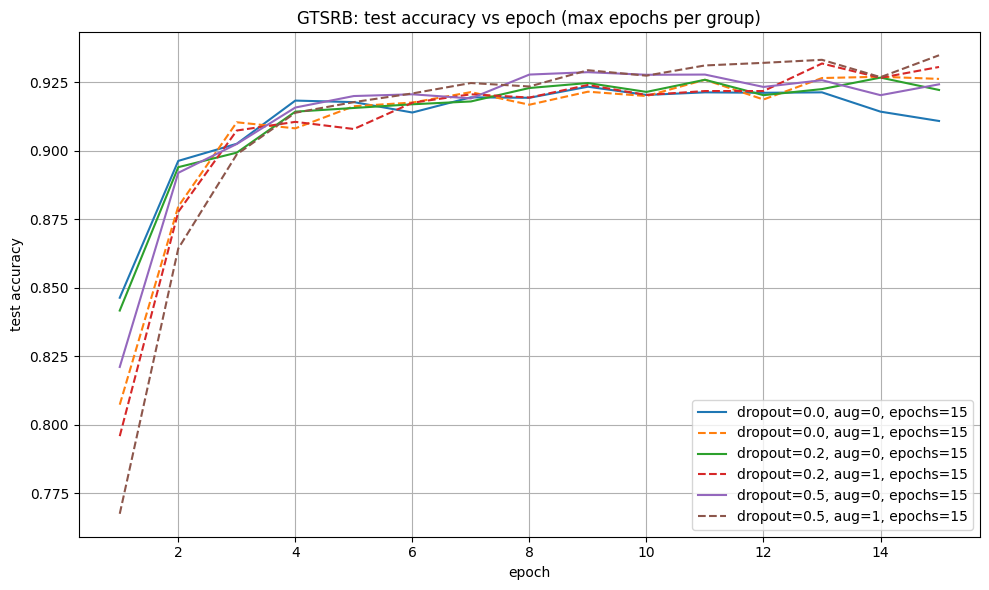

In [7]:
# test accuracy vs epoch

_ = plot_eval_acc_max_per_group("runs/LENET5/GTSRB", save_path="plots_for_analysis/gtsrb_test_acc.png")

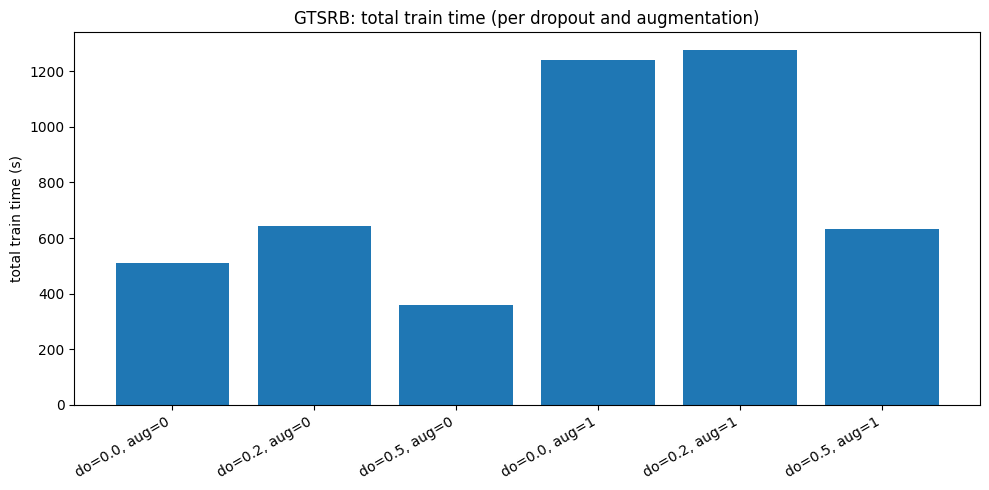

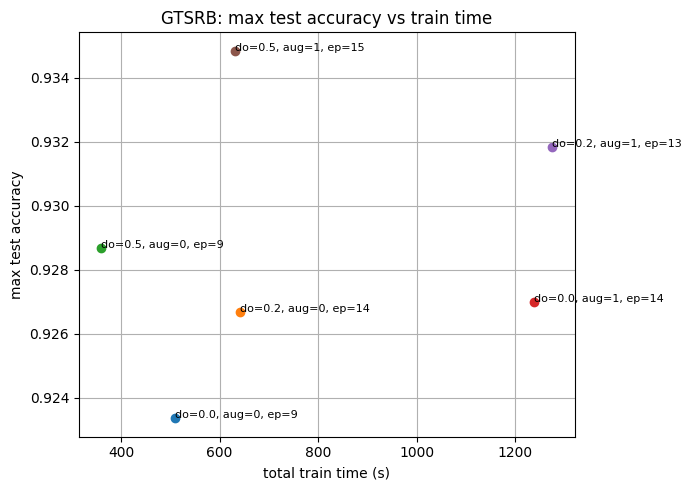

In [8]:
# train time depending on config

dataset_dir = Path("runs/LENET5/GTSRB")  

best = load_best_runs_per_group(dataset_dir)
rows = runtime_summary(best, threshold=0.60)

# print_runtime_table(rows)
plot_total_time(rows, title=f"{dataset_dir.name}: total train time (per dropout and augmentation)")
plot_efficiency(rows, title=f"{dataset_dir.name}: max test accuracy vs train time")

dropout=0.0, aug=0 | MIN epochs=1 | last test acc=0.8463
dropout=0.0, aug=0 | MAX epochs=15 | last test acc=0.9108


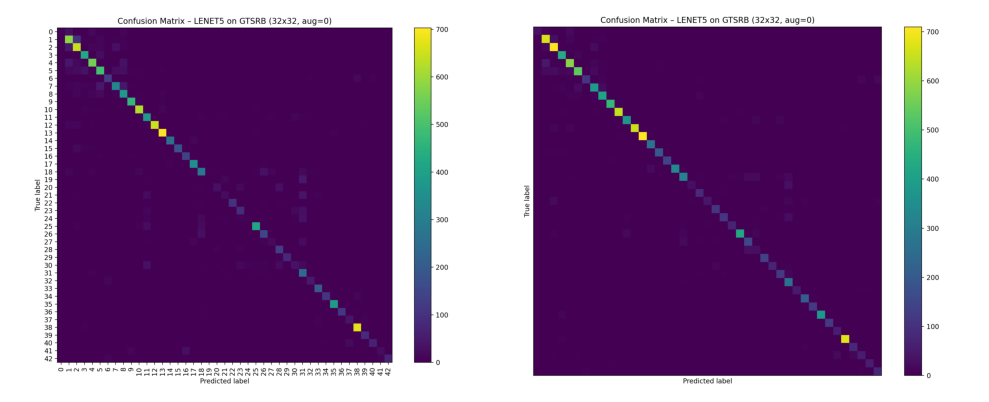

dropout=0.0, aug=1 | MIN epochs=1 | last test acc=0.8073
dropout=0.0, aug=1 | MAX epochs=15 | last test acc=0.9262


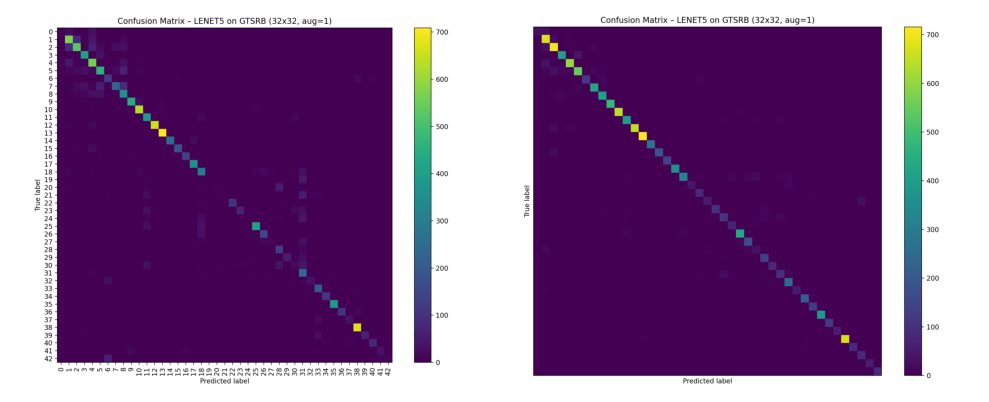

In [9]:
# inspecting differences in confusion matrix for aug=0 and aug=1

_ = show_confusion_pngs_for_setting(
    "runs/LENET5/GTSRB",
    dropout=0.0,
    augment=0,
)
_ = show_confusion_pngs_for_setting(
    "runs/LENET5/GTSRB",
    dropout=0.0,
    augment=1,
)

In [10]:
# best configs

runs_root = Path("runs/LENET5") 

dataset = "gtsrb"
df = build_lenet5_best_per_config_df(
            runs_root,
            dataset,
            group_keys=("dropout", "augment"),
            out_csv_path=f"tables/lenet5_{dataset}_best_per_config.csv",
        )
# print("\n", dataset.upper(), "\n", df)
print(df.to_string())



   dropout  augment  best_test_acc  best_test_acc_epoch  total_train_s  total_test_s
0      0.5        1       0.934838                   15     631.983772     84.830803
1      0.2        1       0.931829                   13    1104.161671    144.651276
2      0.5        0       0.928662                    9     254.709653     64.329514


In [11]:
# looking at a report of one specific config

df = report_table_for_config(
    "runs/LENET5/GTSRB",
    dropout=0.0,
    augment=0,
    epochs=5
)

Run: lenet5_gtsrb32_aug0_do0.0_ep5_optadam0.001_dbg1.0_s42_acttanh_adapt0_20260126-012237
dropout=0.0, augment=0, epochs=5
    class  precision  recall  f1_score  support
        0      0.867   0.867     0.867       60
        1      0.872   0.910     0.891      720
       10      0.970   0.971     0.970      660
       11      0.941   0.907     0.924      420
       12      0.992   0.938     0.964      690
       13      0.982   0.992     0.987      720
       14      0.961   1.000     0.980      270
       15      0.940   0.900     0.920      210
       16      0.935   0.960     0.947      150
       17      0.994   0.961     0.977      360
       18      0.934   0.756     0.836      390
       19      0.736   0.650     0.690       60
        2      0.864   0.965     0.912      750
       20      0.784   0.844     0.813       90
       21      0.588   0.522     0.553       90
       22      0.921   0.875     0.897      120
       23      0.883   0.807     0.843      150
       24    

# Analysing CIFAR-10

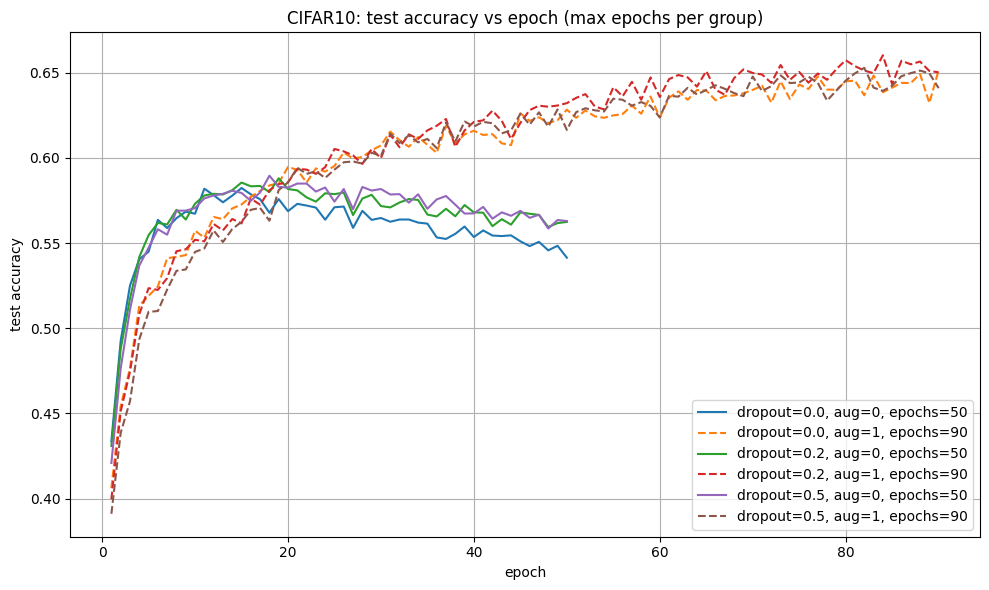

In [12]:
# test accuracy vs epoch

_ = plot_eval_acc_max_per_group("runs/LENET5/CIFAR10", save_path="plots_for_analysis/cifar10_test_acc.png")

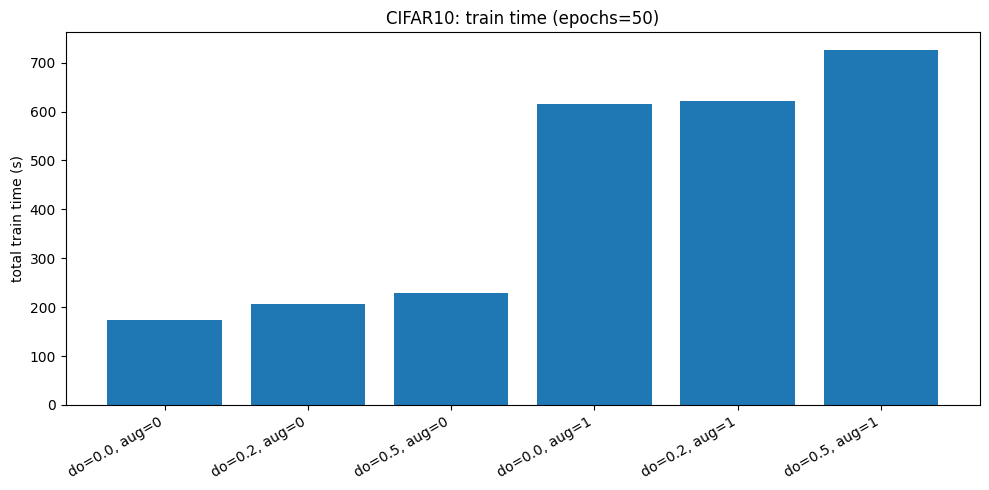

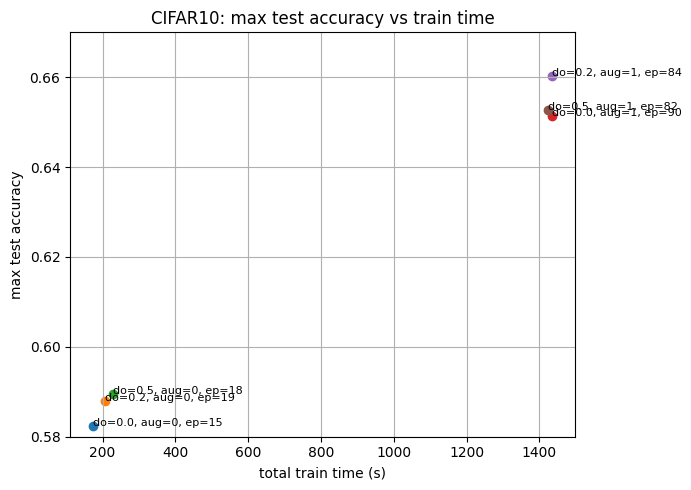

In [13]:
# train time depending on config

def load_best_runs_per_group_fixed_epochs(dataset_dir: str | Path, target_epochs: int):
    """
    Like load_best_runs_per_group(...), but ONLY considers runs where config['epochs'] == target_epochs.
    If multiple runs exist per (dropout, augment) at that epoch setting, keeps the one with the longest
    history (safety) and/or latest run_dir name ordering.
    """
    dataset_dir = Path(dataset_dir)
    run_dirs = [
        p for p in dataset_dir.iterdir()
        if p.is_dir() and (p / "config.json").exists() and (p / "history.json").exists()
    ]

    runs = []
    for rd in run_dirs:
        cfg = _load_json(rd / "config.json")
        hist = _load_json(rd / "history.json")

        # treat eval_* as TEST, but keep field names unchanged
        eval_acc = hist.get("eval_acc", [])
        train_t = hist.get("train_time_s", [])
        eval_t = hist.get("eval_time_s", [])

        if not eval_acc or not train_t or not eval_t:
            continue

        # filter by epochs in config
        try:
            epochs_cfg = int(cfg.get("epochs"))
        except Exception:
            continue
        if epochs_cfg != int(target_epochs):
            continue

        dropout = float(cfg.get("dropout"))
        augment = int(cfg.get("augment"))

        runs.append({
            "run_dir": rd,
            "dropout": dropout,
            "augment": augment,
            "eval_acc": eval_acc,
            "train_time_s": train_t,
            "eval_time_s": eval_t,
        })

    best = {}
    for r in runs:
        key = (r["dropout"], r["augment"])
        if key not in best:
            best[key] = r
            continue

        # prefer longer history (safety); if tie, prefer "later" run_dir name (often timestamped)
        if len(r["eval_acc"]) > len(best[key]["eval_acc"]):
            best[key] = r
        elif len(r["eval_acc"]) == len(best[key]["eval_acc"]) and r["run_dir"].name > best[key]["run_dir"].name:
            best[key] = r

    if not best:
        raise RuntimeError(f"No usable runs found in {dataset_dir} with epochs=={target_epochs}")

    return best


dataset_dir = Path("runs/LENET5/CIFAR10")  

best = load_best_runs_per_group(dataset_dir)
rows = runtime_summary(best, threshold=0.60)

best_50 = load_best_runs_per_group_fixed_epochs("runs/LENET5/CIFAR10", target_epochs=50)
rows_50 = runtime_summary(best_50, threshold=0.60)
plot_total_time(rows_50, title="CIFAR10: train time (epochs=50)")

# print_runtime_table(rows)
# plot_total_time(rows, title=f"{dataset_dir.name}: total train time (per dropout and augmentation)",  dataset_name=dataset_dir.name, normalize_epochs=15)
plot_efficiency(rows, title=f"{dataset_dir.name}: max test accuracy vs train time", dataset_name=dataset_dir.name)

dropout=0.0, aug=0 | MIN epochs=1 | last test acc=0.4337
dropout=0.0, aug=0 | MAX epochs=50 | last test acc=0.5414


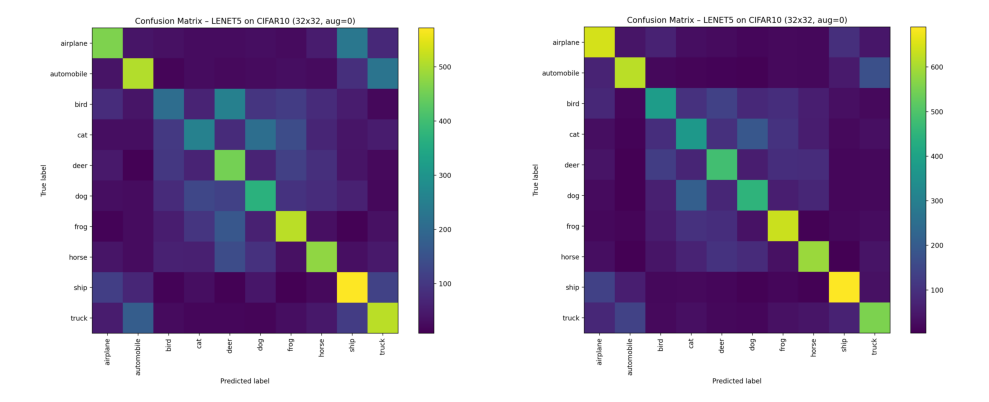

dropout=0.0, aug=1 | MIN epochs=1 | last test acc=0.4062
dropout=0.0, aug=1 | MAX epochs=90 | last test acc=0.6514


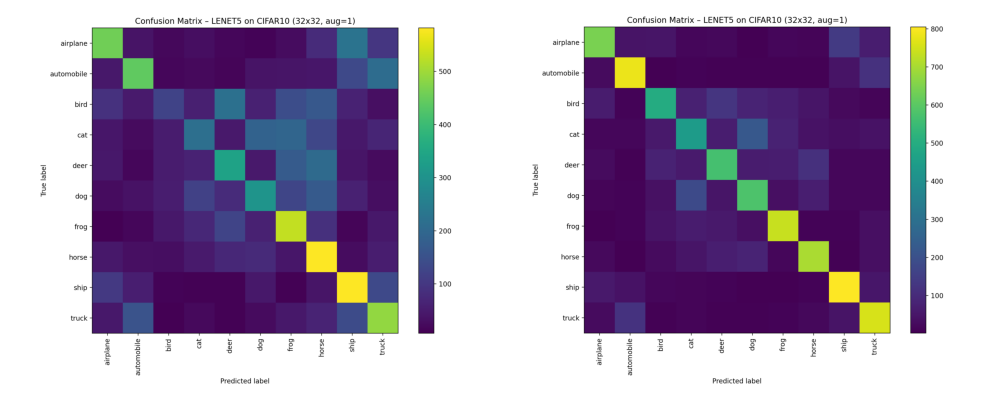

In [14]:
_ = show_confusion_pngs_for_setting(
    "runs/LENET5/CIFAR10",
    dropout=0.0,
    augment=0,
)
_ = show_confusion_pngs_for_setting(
    "runs/LENET5/CIFAR10",
    dropout=0.0,
    augment=1,
)

In [15]:
# best configs
runs_root = Path("runs/LENET5/CIFAR10") 

dataset = "cifar10"
df = build_lenet5_best_per_config_df(
            runs_root,
            dataset,
            group_keys=("dropout", "augment"),
            out_csv_path=f"tables/lenet5_{dataset}_best_per_config.csv",
        )
# print("\n", dataset.upper(), "\n", df)
print(df.to_string())

   dropout  augment  best_test_acc  best_test_acc_epoch  total_train_s  total_test_s
0      0.2        1         0.6602                   84    1343.974303     77.654338
1      0.5        1         0.6528                   82    1295.778932     77.666446
2      0.0        1         0.6514                   90    1433.943636     82.753428


In [ ]:
# getting into latex table

latex = df_to_latex_table_extrema_bold(
    df,
    caption="CIFAR10: Top 3 models",
    label="tab:cifar10_top3",
    # percent_cols=["Balanced Accuracy (%)", "F1 Macro (%)", "ROC-AUC (%)"],  # nur falls deine Werte 0..1 sind
    float_fmt="{:.2f}",
)
print(latex)

\begin{table}[H]
\centering
\begin{tabular}{|l|c|c|c|c|c|}
\hline
 \textbf{dropout} & \textbf{augment} & \textbf{best_test_acc} & \textbf{best_test_acc_epoch} & \textbf{total_train_s} & \textbf{total_test_s} \\ \hline
 \textbf{0.20} & \textbf{1.00} & \textbf{0.66} & 84.00 & 1343.97 & \textbf{77.65} \\ \hline
 \textbf{0.50} & \textbf{1.00} & 0.65 & \textbf{82.00} & \textbf{1295.78} & 77.67 \\ \hline
 \textbf{0.00} & \textbf{1.00} & \textbf{0.65} & \textbf{90.00} & \textbf{1433.94} & \textbf{82.75} \\ \hline
\end{tabular}
\caption{CIFAR10: Top 3 models}
\label{tab:cifar10_top3}
\end{table}


In [17]:
# looking at a report of one specific config

df = report_table_for_config(
    "runs/LENET5/CIFAR10",
    dropout=0.0,
    augment=0,
    epochs=5,
)

Run: lenet5_cifar1032_aug0_do0.0_ep5_optadam0.001_dbg1.0_s42_acttanh_adapt0_20260126-051802
dropout=0.0, augment=0, epochs=5
     class  precision  recall  f1_score  support
  airplane      0.572   0.628     0.599     1000
automobile      0.733   0.568     0.640     1000
      bird      0.404   0.507     0.450     1000
       cat      0.394   0.388     0.391     1000
      deer      0.531   0.374     0.439     1000
       dog      0.516   0.379     0.437     1000
      frog      0.518   0.713     0.600     1000
     horse      0.574   0.677     0.621     1000
      ship      0.682   0.621     0.650     1000
     truck      0.606   0.595     0.600     1000
 macro avg      0.553   0.545     0.543    10000


In [18]:
# getting into latex table

latex = df_to_latex_table_extrema_bold(
    df,
    caption="CIFAR10: Report after 5 epochs (aug=0, do=0)",
    label="tab:cifar10_report",
    # percent_cols=["Balanced Accuracy (%)", "F1 Macro (%)", "ROC-AUC (%)"],  # nur falls deine Werte 0..1 sind
    float_fmt="{:.2f}",
)
print(latex)


\begin{table}[H]
\centering
\begin{tabular}{|l|c|c|c|c|}
\hline
 \textbf{class} & \textbf{precision} & \textbf{recall} & \textbf{f1_score} & \textbf{support} \\ \hline
 \textbf{airplane} & 0.57 & 0.63 & 0.60 & \textbf{1000} \\ \hline
 \textbf{automobile} & \textbf{0.73} & 0.57 & 0.64 & \textbf{1000} \\ \hline
 \textbf{bird} & 0.40 & 0.51 & 0.45 & \textbf{1000} \\ \hline
 \textbf{cat} & \textbf{0.39} & 0.39 & \textbf{0.39} & \textbf{1000} \\ \hline
 \textbf{deer} & 0.53 & \textbf{0.37} & 0.44 & \textbf{1000} \\ \hline
 \textbf{dog} & 0.52 & 0.38 & 0.44 & \textbf{1000} \\ \hline
 \textbf{frog} & 0.52 & \textbf{0.71} & 0.60 & \textbf{1000} \\ \hline
 \textbf{horse} & 0.57 & 0.68 & 0.62 & \textbf{1000} \\ \hline
 \textbf{ship} & 0.68 & 0.62 & \textbf{0.65} & \textbf{1000} \\ \hline
 \textbf{truck} & 0.61 & 0.59 & 0.60 & \textbf{1000} \\ \hline
 \textbf{macro avg} & 0.55 & 0.55 & 0.54 & \textbf{10000} \\ \hline
\end{tabular}
\caption{CIFAR10: Report after 5 epochs (aug=0, do=0)}
\label{tab: